# TensorFlow Tutorial


主要就是熟悉 tensorflow的一些操作。

出现一个bug：
```
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
```

这里 logits和labels必须是  (None, n_y) shape。 就是样本数在前， n_y在后。否则计算会出错。


tensorflow 的一个问题是， session与variable之间的关系。 如果想保留参数应该怎么做？ 

参考 https://www.tensorflow.org/programmers_guide/graphs


一种方法： 就是将parameters保存下来，然后再用来做预测。 有点小麻烦。不如将其封装好。



## 1 - Exploring the Tensorflow Library


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now that you have imported the library, we will walk you through its different applications. You will start with an example, where we compute for you the loss of one training example. 
$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2 \tag{1}$$

In [2]:
y_hat = tf.constant(36, name='y_hat')            # Define y_hat constant. Set to 36.
y = tf.constant(39, name='y')                    # Define y. Set to 39

loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss

init = tf.global_variables_initializer()         # When init is run later (session.run(init)),
                                                 # the loss variable will be initialized and ready to be computed
with tf.Session() as session:                    # Create a session and print the output
    session.run(init)                            # Initializes the variables
    print(session.run(loss))                     # Prints the loss

9


In [3]:
a = tf.constant(2)
b = tf.constant(10)
c = tf.multiply(a,b)
print(c)
with tf.Session() as sess:
    sess.run(c)

Tensor("Mul:0", shape=(), dtype=int32)


In [4]:
# Change the value of x in the feed_dict
with tf.Session() as sess:
    x = tf.placeholder(tf.int64, name = 'x')
    print(sess.run(2 * x, feed_dict = {x: 3}))

6


### 1.4 - Using One Hot encodings

Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert as follows:


<img src="images/onehot.png" style="width:600px;height:150px;">

This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In tensorflow, you can use one line of code: 

- tf.one_hot(labels, depth, axis) 

**Exercise:** Implement the function below to take one vector of labels and the total number of classes $C$, and return the one hot encoding. Use `tf.one_hot()` to do this. 

In [5]:
# GRADED FUNCTION: one_hot_matrix

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, C, axis=0)  # axis == 0: depth * num_labels
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [6]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C = 4)
print ("one_hot = " + str(one_hot))

one_hot = [[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **one_hot**
        </td>
        <td>
        [[ 0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.]]
        </td>
    </tr>

</table>


# 2 - Building your first neural network in tensorflow


识别手势对应数字。这个在CNN中还要重新做一遍。

In [7]:

# Loading the dataset
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


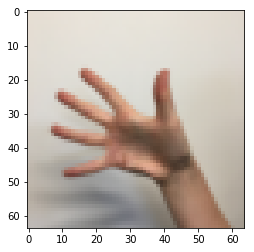

In [8]:
# Example of a picture
index = 78
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [9]:
X_train_orig.shape

(1080, 64, 64, 3)

In [10]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 12288
number of test examples = 12288
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


In [11]:
tf.reset_default_graph()


def create_model(n_x, n_1, n_2, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_x))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))

    W1 = tf.get_variable("W1", [n_x, n_1], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [1, n_1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [n_1, n_2], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [1, n_2], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n_2, n_y], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [1, n_y], initializer = tf.zeros_initializer())

    Z1 = tf.add(tf.matmul(X, W1), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    # cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return X, Y, Z3, cost, parameters

In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()   # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)       # to keep consistent results
    seed = 3                    # to keep consistent results
    
    # create model
    m, n_x = X_train.shape
    n_1 = 25
    n_2 = 12
    n_y = Y_train.shape[1]
    X, Y, Z3, cost, parameters = create_model(n_x, n_1, n_2, n_y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    costs = [] 
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.  
#             seed = seed + 1
#             np.random.seed(seed)
            permutation = list(np.random.permutation(m))
            shuffled_X = X_train[permutation, :]
            shuffled_Y = Y_train[permutation, :]  
            for i in range(0, m, minibatch_size):
                minibatch_X = shuffled_X[i:i+minibatch_size, :]
                minibatch_Y = shuffled_Y[i:i+minibatch_size, :]
                
                _ , minibatch_cost = sess.run([optimizer, cost], 
                                              feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost * minibatch_X.shape[0] / m

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # save parameters
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.813675
Cost after epoch 100: 0.947718
Cost after epoch 200: 0.786838
Cost after epoch 300: 0.696449
Cost after epoch 400: 0.592870
Cost after epoch 500: 0.527524
Cost after epoch 600: 0.429888
Cost after epoch 700: 0.375939
Cost after epoch 800: 0.302896
Cost after epoch 900: 0.254351
Cost after epoch 1000: 0.207596
Cost after epoch 1100: 0.178134
Cost after epoch 1200: 0.135089
Cost after epoch 1300: 0.106702
Cost after epoch 1400: 0.081691


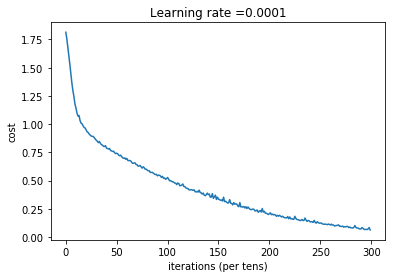

Parameters have been trained!
Train Accuracy: 0.98703706
Test Accuracy: 0.7416667
CPU times: user 1min 35s, sys: 45.9 s, total: 2min 20s
Wall time: 1min 57s


In [13]:
%%time
parameters = model(X_train, Y_train, X_test, Y_test)

**Expected Output**:

<table> 
    <tr> 
        <td>
            **Train Accuracy**
        </td>
        <td>
        0.999074
        </td>
    </tr>
    <tr> 
        <td>
            **Test Accuracy**
        </td>
        <td>
        0.716667
        </td>
    </tr>

</table>

改变seed的条件。实际上随机的效果就很好！！ test 的准确率可以达到 89%

In [50]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    x = tf.placeholder("float", [1, 12288])
    
    Z1 = tf.add(tf.matmul(x, W1), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    p = tf.argmax(Z3, axis=1)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [53]:
s = 0
for p in parameters[2].values():
    s += np.prod(p.shape)
print(s)

307615


Your algorithm predicts: y = 3


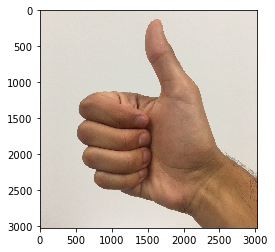

In [52]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3))
my_image_prediction = predict(my_image, parameters[2])

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

<font color='blue'>
**What you should remember**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.